In [1]:
import numpy as np
import pandas as pd
import random
import pickle
import math
random.seed = 456

In [2]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer

In [3]:
from matplotlib import pyplot as plt

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV

In [5]:
def tf(list_keywords):
    res = []
    for keywords in list_keywords:
        sum_val = sum(keywords.values())
        keywords = keywords.copy()
        for word in keywords:
            keywords[word] /= sum_val
        res.append(keywords)
    return res


def tfidf(list_keywords):
    idf = dict.fromkeys(list_keywords[0].keys(), 0.0)

    for keywords in list_keywords:
        for word, _ in filter(lambda x: x[1] > 0, keywords.items()):
            idf[word] += 1.0

    for word in idf:
        if idf[word]:
            idf[word] = math.log(len(list_keywords) / idf[word])

    res = []
    for keywords in list_keywords:
        keywords = keywords.copy()
        s = sum(keywords.values())
        for word, _ in filter(lambda x: x[1] > 0, keywords.items()):
            keywords[word] *= idf[word] / s
        res.append(keywords)
    return res


def tfc(list_keywords):
    list_keywords = tfidf(list_keywords)
    keywords = list_keywords[0].keys()
    res_list = []
    for i, val in enumerate(list_keywords):
        norm = 0
        for v in val.values():
            norm += v**2
        norm = math.sqrt(norm)
        #norm = length_vector(val.values())

        if norm == 0:
            res_list.append(dict(zip(keywords, val.values())))
            continue
        res = map(lambda x: x / norm, val.values())
        res_list.append(dict(zip(keywords, res)))

    return res_list

In [6]:
def word_cloud(word_bag, name, ax=None):

    wc = WordCloud(background_color="white", height=500, width=1000,random_state=random.seed)
    wc.generate_from_frequencies(word_bag)
    if ax is not None:
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(name)
        ax.axis(False)
    else:
        plt.subplots(num=None, figsize=(15, 10), dpi=80)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(name)
        plt.axis("off")

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
with open('stop_words_ru.txt','r',encoding='utf-8') as ar:
    extra_stop_words = ar.readlines()

In [9]:
extra_stop_words = set([stop_word[:-1] for stop_word in extra_stop_words])

In [10]:
stemmer = SnowballStemmer(language='russian')
morph = MorphAnalyzer()
set_stopwords = set(stopwords.words('russian')).union(extra_stop_words)
set_punctuation = set(string.punctuation+'—'+'«'+'»')

In [11]:
def preproc_lemm_nltk(text):
    temp_tokens = []
    tokens = word_tokenize(text.lower())
    for word in tokens:
        lemm_word = morph.normal_forms(word)[0]
        if lemm_word not in set_stopwords and lemm_word not in set_punctuation and not(any(map(lambda c: c in string.ascii_letters+'\u200b', lemm_word))) and not(any(map(lambda c: c in string.digits, lemm_word))):
            temp_tokens.append(lemm_word)
    return temp_tokens

In [12]:
def total_bag(results):
    dict_words = dict()
    for result in results:
        tokens = preproc_lemm_nltk(result['abstract'])
        for token in tokens:
            if token not in dict_words:
                dict_words[token] = 1
            else:
                dict_words[token] += 1
    return dict_words

In [13]:
def bag_article(abstract,bag):
    tokens = preproc_lemm_nltk(abstract)
    for token in tokens:
        if token in bag:
            bag[token] += 1
    return bag

In [14]:
def cut_low_freq_words(bag_words,number=0):       
    temp_dict = dict()
    for word in bag_words:
        if bag_words[word] > number:
            temp_dict[word] = bag_words[word]
    return temp_dict

In [15]:
def make_list_keywords(bag_words,results):       
    list_keywords = []
    temp_bag = dict.fromkeys(bag_words, 0)
    for result in results:
        list_keywords.append(bag_article(result['abstract'],temp_bag.copy()))
    del temp_bag
    return list_keywords

In [16]:
def make_list_keywords_weight_items(list_keywords_weight):       
    list_keywords_weight_items = []
    for item in list_keywords_weight:
        list_keywords_weight_items.append(list(item.values()))
    return list_keywords_weight_items

In [17]:
def classifier_scores(model, x_train, y_train, x_test=None, y_test=None):
    cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    scores = cross_validate(model,X_train,y_train,cv=cv,return_estimator=True,scoring=['accuracy','precision','recall','f1_micro'])
    return cv, scores

In [18]:
def classifier_plot(list_cv,list_scores, x_train, y_train, x_test=None,y_test=None):

    list_num_best_models = []
    for i in range(len(list_scores)):
        list_num_best_models.append(list_scores[i]['test_f1_micro'].argmax())

    models =[]
    for i in range(len(list_scores)):
        models.append(list_scores[i]['estimator'][list_num_best_models[i]])
    
    list_x_test = []
    list_y_test = []
    for j in range(len(list_num_best_models)):
        if x_test is None and y_test is None:
            _, test_num = list(list_cv[j].split(x_train,y_train))[list_num_best_models[j]]
            x_test, y_test = [], []
            for i in test_num:
                x_test.append(x_train[i])
                y_test.append(y_train[i])
            list_x_test.append(x_test)
            list_y_test.append(y_test)
            x_test = None
            y_test = None

    list_y_proba = []
    for i in range(len(models)):
        list_y_proba.append(models[i].predict_proba(list_x_test[i])[:,1])
    
    list_fpr = [0] * len(list_y_proba)
    list_tpr = [0] * len(list_y_proba)
    for i in range(len(list_y_proba)):
        list_fpr[i], list_tpr[i], _ = roc_curve(list_y_test[i], list_y_proba[i])

    #name = f'{str(model).split("(")[0]}\nAUC = {round(roc_auc_score(list_y_test[i], y_proba),5)}'
    plt.figure(figsize=(15,10))
    lw = 2
    for i in range(len(list_tpr)):
        plt.plot(
            list_fpr[i],
            list_tpr[i],
            #color="darkorange",
            lw=lw,
            label=f'{str(models[i]).split("(")[0]}\nAUC = {round(roc_auc_score(list_y_test[i], list_y_proba[i]),5)}'
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #plt.title(name)
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
with open('results_iad_translate.pkl','rb') as ar:
    results_iad = pickle.load(ar)

In [20]:
with open('results_no_iad_translate.pkl','rb') as ar:
    results_no_iad = pickle.load(ar)

In [21]:
results_iad[0]

{'title': 'Мощные нападающие за счет кластеризации с сохранением кластеров',
 'link': 'https://dl.acm.org/doi/10.1145/3339185',
 'authors': ['Kasper Green Larsen',
  'Jelani Nelson',
  'Huy L. Nguyễn',
  'Mikkel Thorup'],
 'date': 'август 2019 г.',
 'abstract': 'Мы разрабатываем новый алгоритм для задачи тяжелых нападающих турникетов в общих потоках турникетов, EXPANDERSKETCH, который находит приблизительные топ-k элементов во вселенной размера n, используя те же асимптотические O(k log n) слов памяти и O(log n) время обновления как COUNTMIN и COUNTSKETCH, но для ответа на запросы требуется только время O(k poly(log n)) вместо времени O(n log n) для двух других. Понятие «приближение» имеет тот же 12 смысл, что и СЧЕТНЫЙ ЭСКИЗ, который при известных нижних границах является наилучшей гарантией, которую можно достичь в сублинейной памяти. тяжелый нападающий кодируется как некоторая форма зашумленного спектрального кластера на графе, и цель состоит в том, чтобы идентифицировать каждый кла

In [22]:
results_no_iad[0]

{'title': 'ByShard: шардинг в византийской среде',
 'link': 'https://dl.acm.org/doi/10.14778/3476249.3476275',
 'authors': ['Jelle Hellings', 'Mohammad Sadoghi'],
 'date': 'июль 2021 г.',
 'abstract': 'Появление блокчейнов подтолкнуло к развитию устойчивых систем, которые могут справляться с византийскими сбоями из-за сбоев, ошибок или даже злонамеренного поведения. Недавно мы также стали свидетелями исследования сегментирования в этих устойчивых системах, чтобы обеспечить масштабируемость, необходимую для очень больших приложений, основанных на данных. К сожалению, все современные сегментированные устойчивые системы используют специфичные для системы специализированные подходы к сегментированию, которые не обеспечивают гибкости традиционных систем управления сегментированными данными. Чтобы улучшить эту ситуацию, мы принципиально рассмотрим дизайн сегментированных устойчивых систем. Мы делаем это, представляя BYSHARD, объединяющую структуру для изучения сегментированных устойчивых сис

In [23]:
len(results_iad)

1500

In [24]:
len(results_no_iad)

1500

In [25]:
results = results_iad + results_no_iad

In [26]:
bag_words_iad = total_bag(results_iad)

In [27]:
bag_words_no_iad = total_bag(results_no_iad)

In [28]:
bag_words_begin = total_bag(results)

In [29]:
series_words_iad = pd.Series(bag_words_iad,index = bag_words_iad.keys())

In [30]:
series_words_no_iad = pd.Series(bag_words_no_iad,index = bag_words_no_iad.keys())

In [31]:
series_words = pd.Series(bag_words_begin,index = bag_words_begin.keys())

In [32]:
sum(series_words == 1)

4511

In [33]:
len(series_words_iad)

8191

In [34]:
len(series_words_no_iad)

8855

In [35]:
len(series_words)

12012

In [36]:
series_words.sort_values(ascending=False)/len(series_words)

данные                  0.487179
метод                   0.278805
обучение                0.239760
модель                  0.216617
система                 0.209374
                          ...   
брандмауэр              0.000083
двоично-квадратичный    0.000083
попеременно             0.000083
регуляризатор           0.000083
отсеивание              0.000083
Length: 12012, dtype: float64

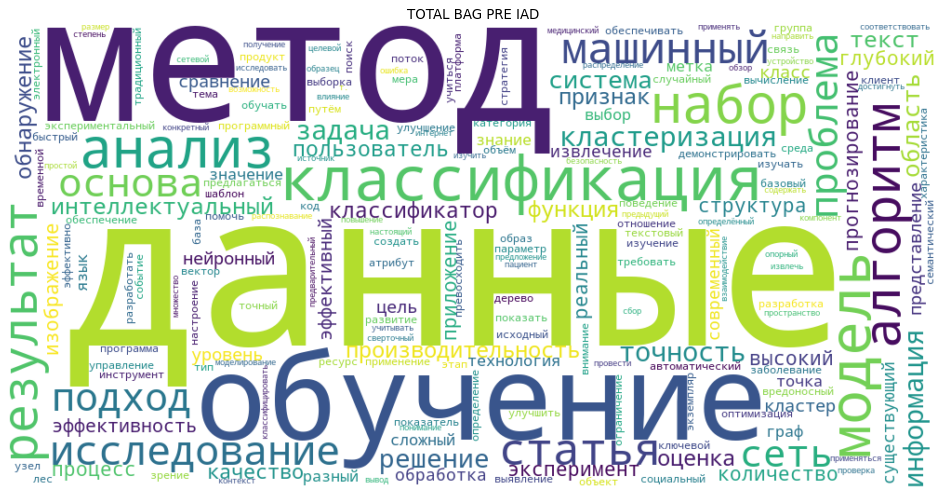

In [37]:
word_cloud(bag_words_iad,'TOTAL BAG PRE IAD')

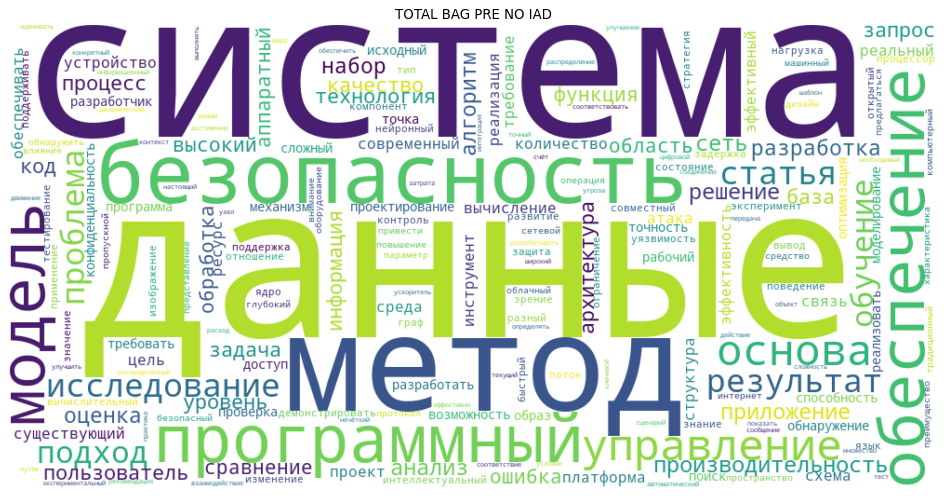

In [38]:
word_cloud(bag_words_no_iad,'TOTAL BAG PRE NO IAD')

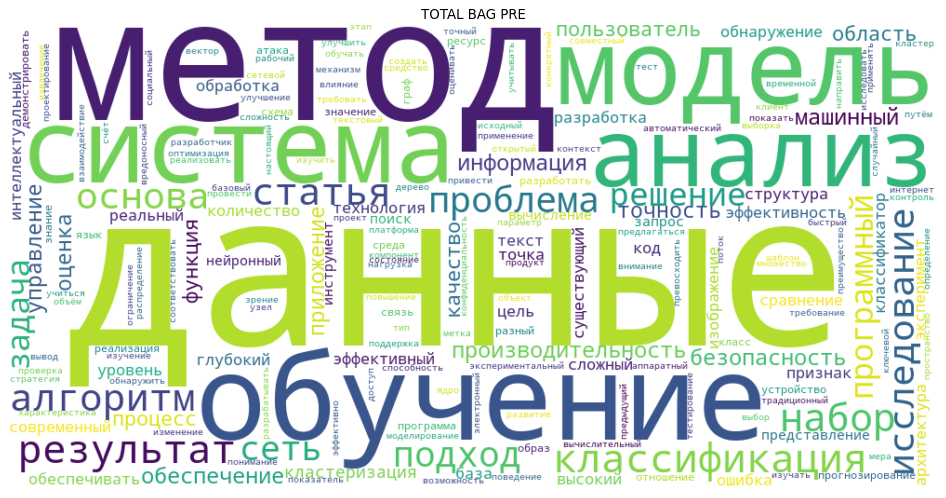

In [39]:
word_cloud(bag_words_begin,'TOTAL BAG PRE')

#### BAG ARTICLE

In [40]:
bag_words=cut_low_freq_words(bag_words_begin,number=1)

In [41]:
list_keywords=make_list_keywords(bag_words,results)

In [42]:
list_keywords_weight = tfc(list_keywords)

In [43]:
list_keywords_weight_items = make_list_keywords_weight_items(list_keywords_weight)

In [44]:
array_keywords_weight_items = np.array(list_keywords_weight_items)

In [45]:
pca = PCA(n_components=2)
pca_keywords = pca.fit_transform(array_keywords_weight_items)

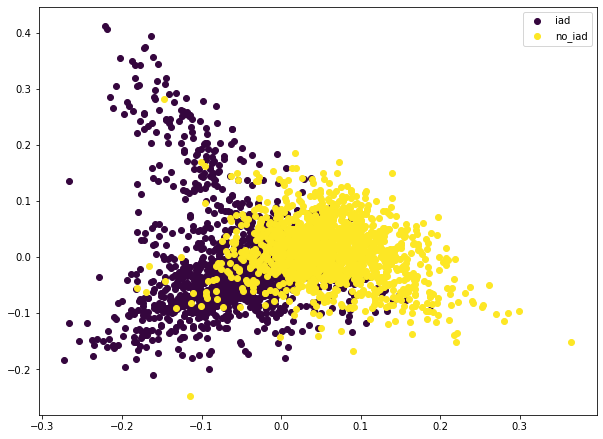

In [54]:
fig = plt.figure(figsize=(10,7.5))
plt.scatter(pca_keywords[:1500,0],pca_keywords[:1500,1],label='iad',c='xkcd:dark purple')
plt.scatter(pca_keywords[1500:,0],pca_keywords[1500:,1],label='no_iad',c='#fde725')
plt.legend()
#plt.xlim((-0.11,0.1))
plt.show()

In [55]:
pca3 = PCA(n_components=3)
pca_keywords3 = pca3.fit_transform(array_keywords_weight_items)

In [56]:
%matplotlib notebook

<IPython.core.display.Javascript object>


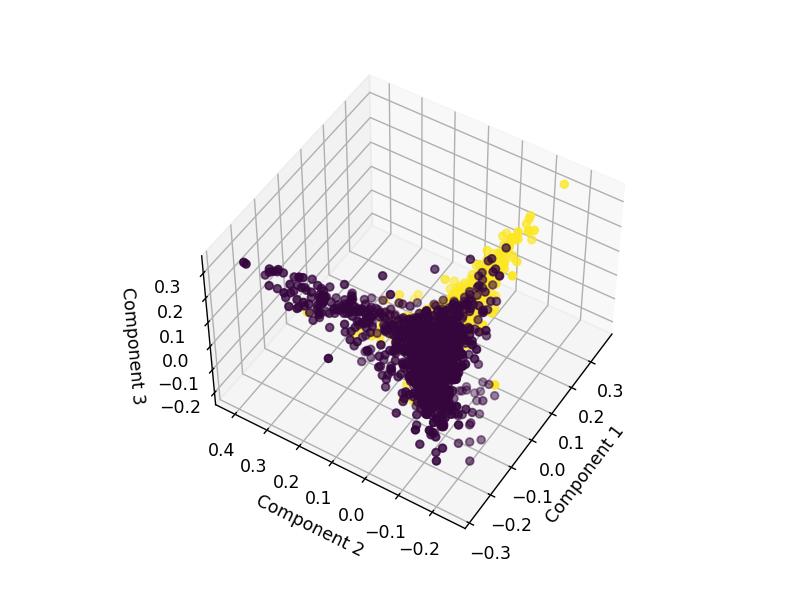

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_keywords3[:1500,0],pca_keywords3[:1500,1],pca_keywords3[:1500,2],label='iad',c='xkcd:dark purple')
ax.scatter(pca_keywords3[1500:,0],pca_keywords3[1500:,1],pca_keywords3[1500:,2],label='no_iad',c='#fde725')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

In [58]:
%matplotlib inline

In [59]:
tsne = TSNE(n_components=2)
tsne_keywords = tsne.fit_transform(array_keywords_weight_items)

C:\Programs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Programs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


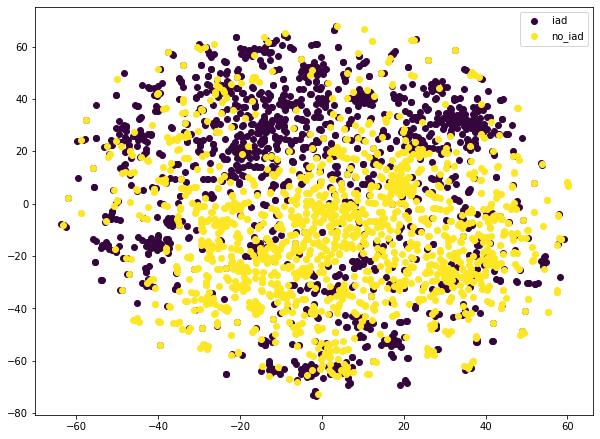

In [62]:
fig = plt.figure(figsize=(10,7.5))
plt.scatter(tsne_keywords[:1500,0],tsne_keywords[:1500,1],label='iad',c='xkcd:dark purple')
plt.scatter(tsne_keywords[1500:,0],tsne_keywords[1500:,1],label='no_iad',c='#fde725')
plt.legend()

In [86]:
list_values = list_keywords_weight[0]
for i in range(1,len(list_keywords_weight)):
    for key in list_keywords_weight[i].keys():
        list_values[key] = list_values[key] + list_keywords_weight[i][key]

In [87]:
list_values_iad = list_keywords_weight[0]
for i in range(1,len(list_keywords_weight)-1500):
    for key in list_keywords_weight[i].keys():
        list_values_iad[key] = list_values_iad[key] + list_keywords_weight[i][key]

In [88]:
list_values_no_iad = list_keywords_weight[1500]
for i in range(1501,len(list_keywords_weight)):
    for key in list_keywords_weight[i].keys():
        list_values_no_iad[key] = list_values_no_iad[key] + list_keywords_weight[i][key]

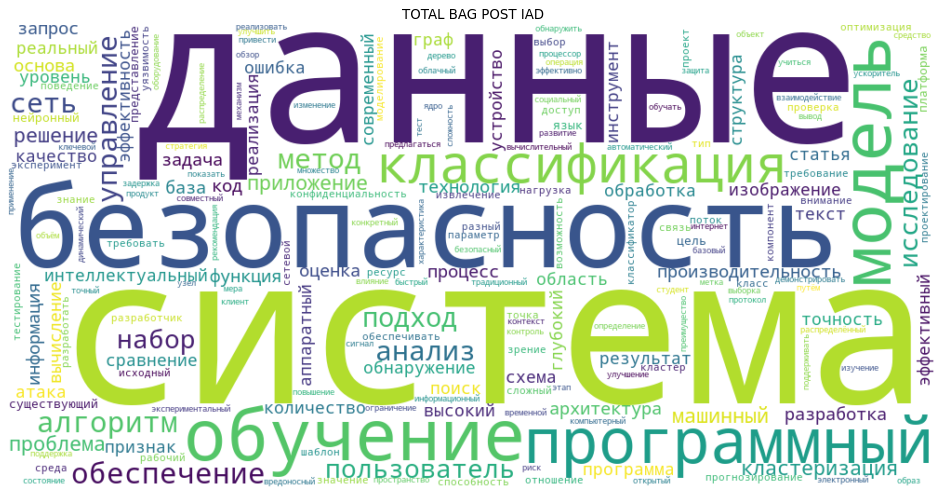

In [89]:
word_cloud(list_values_iad,'TOTAL BAG POST IAD')

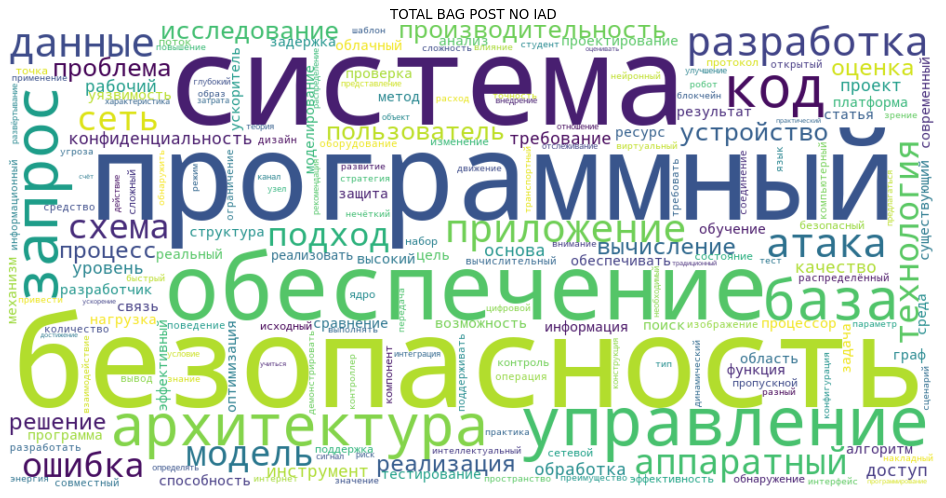

In [90]:
word_cloud(list_values_no_iad,'TOTAL BAG POST NO IAD')

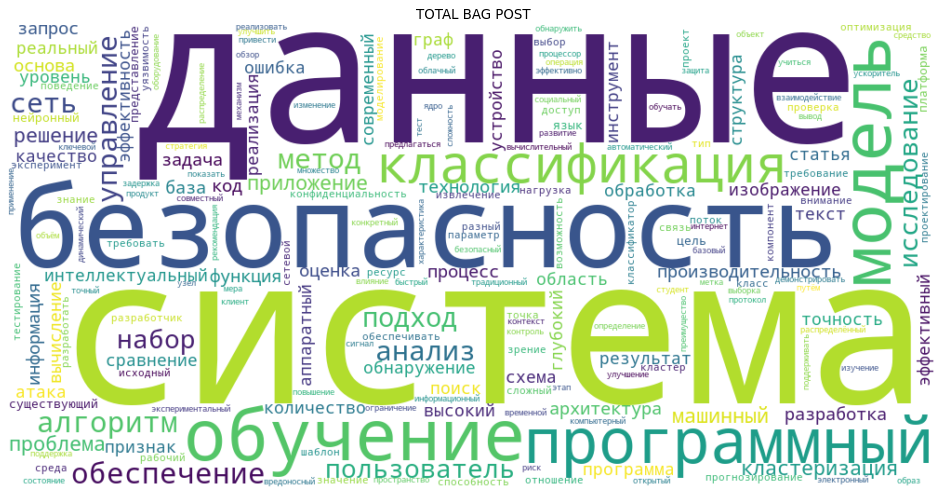

In [91]:
word_cloud(list_values,'TOTAL BAG POST')

#### Кластеризация

In [92]:
labels = np.array([0]*1500+[1]*1500)

In [93]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(array_keywords_weight_items)

KMeans(n_clusters=2)

In [94]:
kmeans_labels = kmeans.predict(array_keywords_weight_items)

In [95]:
sum(kmeans_labels[:1700]==labels[:1700]), sum(kmeans_labels[1700:]==labels[1700:]), sum(kmeans_labels!=labels) # iad, no_iad, error

(266, 152, 2582)

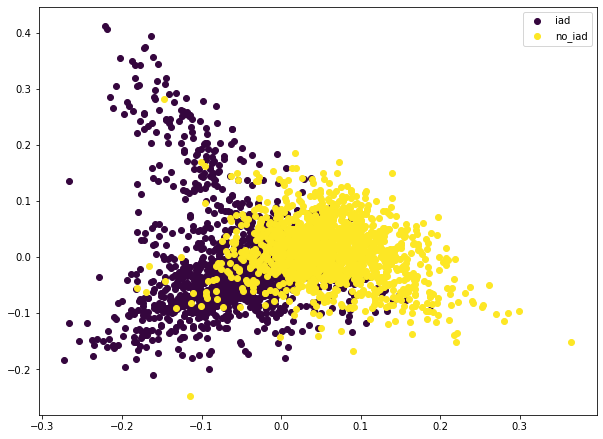

In [96]:
fig = plt.figure(figsize=(10,7.5))
plt.scatter(pca_keywords[:1500,0],pca_keywords[:1500,1],label='iad',c='xkcd:dark purple')
plt.scatter(pca_keywords[1500:,0],pca_keywords[1500:,1],label='no_iad',c='#fde725')
plt.legend()

#### Классификация

In [498]:
gaussiannb=GaussianNB()

In [499]:
i=0
res=[]
res_mean=[]
num_words=[]
while(i<=10): # 100
    bag_words=cut_low_freq_words(bag_words_begin,number=i)
    list_keywords=make_list_keywords(bag_words,results)
    print('hi')
    list_keywords_weight=tfc(list_keywords)
    list_keywords_weight_items=make_list_keywords_weight_items(list_keywords_weight)
    array_keywords_weight_items=np.array(list_keywords_weight_items)
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    r=cross_val_score(gaussiannb, array_keywords_weight_items, labels, cv=strat_k_fold)
    res.append(r)
    res_mean.append(np.mean(r))
    num_words.append(len(bag_words))
    i+=1

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


In [209]:
#with open('res_k_folds.pkl','wb') as pr:
    #pickle.dump(res,pr)

In [210]:
#with open('num_words.pkl','wb') as pr:
    #pickle.dump(num_words,pr)

In [62]:
with open('res_k_folds.pkl','rb') as ar:
    res = pickle.load(ar)
with open('num_words.pkl','rb') as ar:
    num_words = pickle.load(ar)
res_mean = []
for r in res:
    res_mean.append(np.mean(r))

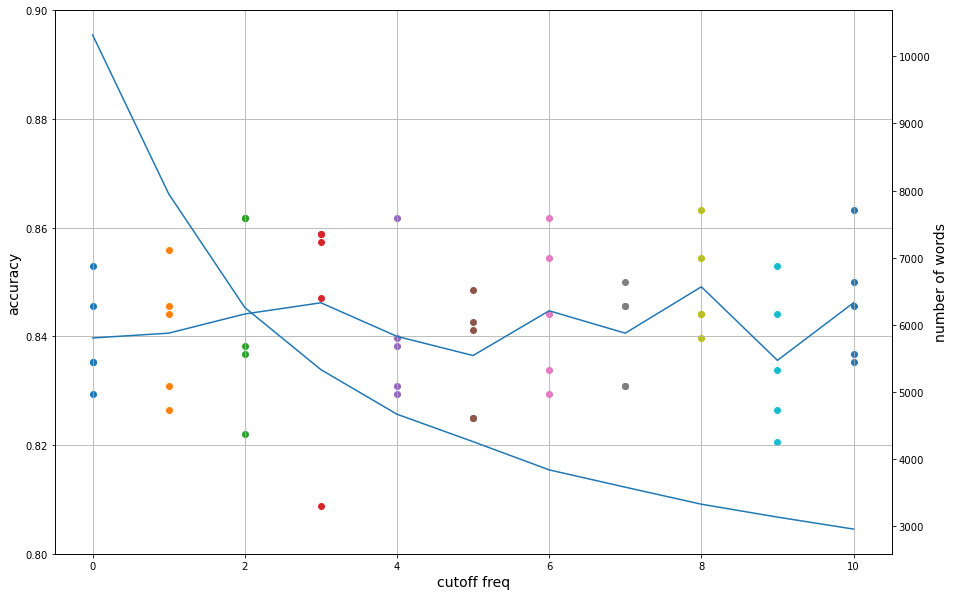

In [516]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax2 = ax.twinx()
for i in range(len(res_mean)):
    ax.scatter([i]*len(res[0]),res[i])
ax.plot(range(len(res_mean)),res_mean)
ax2.plot(range(len(res_mean)),num_words)
ax.set_ylabel("accuracy",fontsize=14)
ax2.set_ylabel("number of words",fontsize=14)
ax.set_ylim((0.8,0.9))
#ax.set_xlim(xmax=100)
ax.grid(True)
#plt.title("name", fontsize=20,color='black')
ax.set_xlabel('cutoff freq', fontsize=14)
plt.show()

In [64]:
num_words[-1]

761

##### Поиск параметров

In [97]:
bag_words=cut_low_freq_words(bag_words_begin,number=11) ###!!! MB ERROR NUMBER
list_keywords=make_list_keywords(bag_words,results)
list_keywords_weight=tfc(list_keywords)
list_keywords_weight_items=make_list_keywords_weight_items(list_keywords_weight)
array_keywords_weight_items=np.array(list_keywords_weight_items)

In [110]:
labels = np.array([0]*1500+[1]*1500)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(array_keywords_weight_items, labels, test_size=0.30, random_state=0)

###### Decision Tree

In [81]:
dtc_gs = GridSearchCV(DecisionTreeClassifier(),
                         {'criterion': ['gini','entropy'],
                          'max_depth': list(range(100,201,20)),
                          'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [2, 5, 10]},
                          n_jobs=6,cv=5,error_score='raise',return_train_score=True)

In [84]:
dtc_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise', estimator=DecisionTreeClassifier(),
             n_jobs=6,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [100, 120, 140, 160, 180, 200],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [85]:
dtc_gs.best_params_ # {'criterion': 'gini', 'max_depth': 140, 'min_samples_leaf': 1, 'min_samples_split': 2}

{'criterion': 'gini',
 'max_depth': 140,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [99]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=140, min_samples_leaf=1, min_samples_split=2)

In [100]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=140)

In [101]:
accuracy_score(dtc.predict(X_test),y_test)

0.8166666666666667

In [102]:
cross_val_score(dtc, array_keywords_weight_items, labels, cv=5)

array([0.80166667, 0.84      , 0.815     , 0.825     , 0.80166667])

###### Random Forest

In [179]:
rfc_gs = GridSearchCV(RandomForestClassifier(bootstrap=True, random_state=0),
                         {'n_estimators': list(range(105,116,5)),
                          'max_depth': list(range(35,46,5)),
                          'max_features': list(range(105,116,5))},
                          n_jobs=-1,cv=5,error_score='raise',return_train_score=True)

In [180]:
rfc_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [35, 40, 45],
                         'max_features': [105, 110, 115],
                         'n_estimators': [105, 110, 115]},
             return_train_score=True)

In [103]:
rfc = RandomForestClassifier(n_estimators=115,bootstrap=False,max_depth=45, max_features=110, min_samples_leaf=3,min_samples_split=11, random_state=456)

In [104]:
# n_estimators=115 #
# max_depth=45 #
# max_features=110 #
# min_samples_leaf=3 #
# min_samples_split=11 #

In [105]:
# 0.930392 - 700, 0.932352 - 800, 0.9333333 - 900, 0.9352941176470588 - 1000, 0.9343137254901961 - 1100
# 0.9343137254901961 - 1200, 0.9333333 - 1500

In [106]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=45, max_features=110,
                       min_samples_leaf=3, min_samples_split=11,
                       n_estimators=115, random_state=456)

In [107]:
accuracy_score(rfc.predict(X_test),y_test)

0.9033333333333333

In [108]:
cross_val_score(rfc, array_keywords_weight_items, labels, cv=5)

array([0.90666667, 0.92333333, 0.89333333, 0.89      , 0.895     ])

In [109]:
_.mean()

0.9016666666666667

In [111]:
cv_rfc, scores_rfc = classifier_scores(RandomForestClassifier(n_estimators=115,bootstrap=False,max_depth=45, max_features=110, min_samples_leaf=3,min_samples_split=11, random_state=456),X_train,y_train)

In [112]:
print('accuracy',scores_rfc['test_accuracy'], scores_rfc['test_accuracy'].mean())
print('precision',scores_rfc['test_precision'], scores_rfc['test_precision'].mean())
print('recall',scores_rfc['test_recall'], scores_rfc['test_recall'].mean())
print('f1_micro',scores_rfc['test_f1_micro'], scores_rfc['test_f1_micro'].mean())

accuracy [0.88809524 0.88809524 0.88333333 0.9047619  0.89285714] 0.8914285714285715
precision [0.90186916 0.91747573 0.89719626 0.93203883 0.89497717] 0.9087114305234631
recall [0.88127854 0.8630137  0.87671233 0.88073394 0.89908257] 0.8801642159943027
f1_micro [0.88809524 0.88809524 0.88333333 0.9047619  0.89285714] 0.8914285714285715


In [113]:
best_rfc=scores_rfc['estimator'][scores_rfc['test_f1_micro'].argmax()]

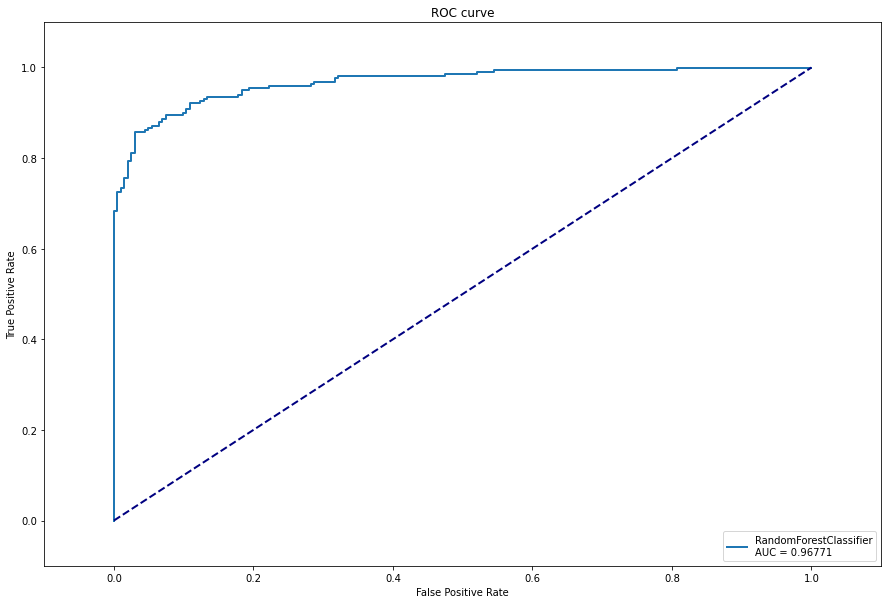

In [114]:
classifier_plot([cv_rfc],[scores_rfc],X_train,y_train)

In [115]:
print(classification_report(y_test,best_rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       493
           1       0.89      0.91      0.90       407

    accuracy                           0.91       900
   macro avg       0.90      0.91      0.90       900
weighted avg       0.91      0.91      0.91       900



###### Logistic Regression

In [68]:
log_reg_gs_1 = GridSearchCV(LogisticRegression(),
                          {'penalty':['l2'],
                           'C':np.logspace(-3,3,7),
                           'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                           n_jobs=-1,cv=5, error_score='raise')

In [61]:
log_reg_gs_2 = GridSearchCV(LogisticRegression(),
                          {'penalty':['l1','l2'],
                           'C':np.logspace(-3,3,7),
                           'solver':['liblinear','saga']},
                           n_jobs=-1,cv=5, error_score='raise')

In [ ]:
log_reg_gs_1.fit(X_train, y_train);

In [ ]:
log_reg_gs_2.fit(X_train, y_train);

In [ ]:
log_reg_gs_1.best_params_ # {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [183]:
log_reg_gs_2.best_params_ # {'C': 10.0, 'penalty': 'l1', 'solver': 'saga'}

{'C': 10.0, 'penalty': 'l1', 'solver': 'saga'}

In [116]:
log_reg = LogisticRegression(penalty='l2',C=10,solver='newton-cg') # best
# log_reg = LogisticRegression(penalty='l1',C=10,solver='saga',max_iter=300)

In [117]:
log_reg.fit(X_train,y_train)

LogisticRegression(C=10, solver='newton-cg')

In [118]:
accuracy_score(log_reg.predict(X_test),y_test) # l2 newton-cg

0.8911111111111111

In [119]:
print(classification_report(y_test,log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       493
           1       0.87      0.90      0.88       407

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



In [120]:
cross_val_score(log_reg, array_keywords_weight_items, labels, cv=5)

array([0.875     , 0.90666667, 0.90333333, 0.885     , 0.87166667])

In [121]:
_.mean()

0.8883333333333334

In [122]:
cv_log_reg, scores_log_reg = classifier_scores(LogisticRegression(penalty='l2',C=10,solver='newton-cg'),X_train,y_train)

In [123]:
print('accuracy',scores_log_reg['test_accuracy'])
print('precision',scores_log_reg['test_precision'])
print('recall',scores_log_reg['test_recall'])
print('f1_micro',scores_log_reg['test_f1_micro'])

accuracy [0.85952381 0.86666667 0.87619048 0.9        0.88809524]
precision [0.84782609 0.87214612 0.86147186 0.92307692 0.86695279]
recall [0.89041096 0.87214612 0.9086758  0.88073394 0.9266055 ]
f1_micro [0.85952381 0.86666667 0.87619048 0.9        0.88809524]


In [125]:
best_log_reg=scores_log_reg['estimator'][scores_log_reg['test_f1_micro'].argmax()]

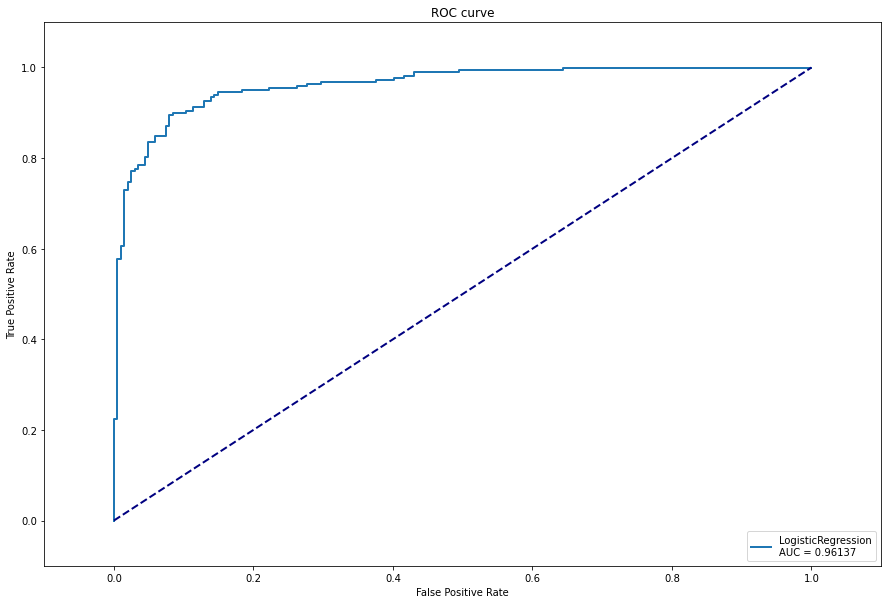

In [126]:
classifier_plot([cv_log_reg],[scores_log_reg],X_train,y_train)

In [127]:
best_log_reg=scores_log_reg['estimator'][scores_log_reg['test_f1_micro'].argmax()]

In [128]:
print(classification_report(y_test,best_log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       493
           1       0.87      0.91      0.89       407

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



###### K-Nearest Neighbors

In [ ]:
KNeighborsClassifier()

In [306]:
knn_gs = GridSearchCV(KNeighborsClassifier(n_neighbors=30),
                         {'n_neighbors':list(range(195,205,1)),
                          'weights':['distance'],
                          'metric':['cosine']},
                          n_jobs=-1,cv=5,error_score='raise')

In [307]:
knn_gs.fit(X_train,y_train);

In [308]:
knn_gs.best_params_ # {'metric': 'cosine', 'n_neighbors': 201, 'weights': 'distance'}

{'metric': 'cosine', 'n_neighbors': 201, 'weights': 'distance'}

In [129]:
knn = KNeighborsClassifier(n_neighbors=201, weights='distance', metric='cosine')

In [130]:
knn.fit(X_train,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=201, weights='distance')

In [131]:
accuracy_score(knn.predict(X_test),y_test)

0.8777777777777778

In [132]:
print(classification_report(y_test,knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       493
           1       0.86      0.87      0.87       407

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



In [133]:
cross_val_score(knn, array_keywords_weight_items, labels, cv=5)

array([0.87166667, 0.89833333, 0.87333333, 0.87      , 0.84666667])

In [134]:
cv_knn, scores_knn = classifier_scores(KNeighborsClassifier(n_neighbors=201, weights='distance', metric='cosine'),X_train,y_train)

In [135]:
print('accuracy',scores_knn['test_accuracy'])
print('precision',scores_knn['test_precision'])
print('recall',scores_knn['test_recall'])
print('f1_micro',scores_knn['test_f1_micro'])

accuracy [0.85238095 0.88571429 0.86904762 0.87619048 0.86904762]
precision [0.85520362 0.92537313 0.88679245 0.91089109 0.86222222]
recall [0.8630137  0.84931507 0.85844749 0.8440367  0.88990826]
f1_micro [0.85238095 0.88571429 0.86904762 0.87619048 0.86904762]


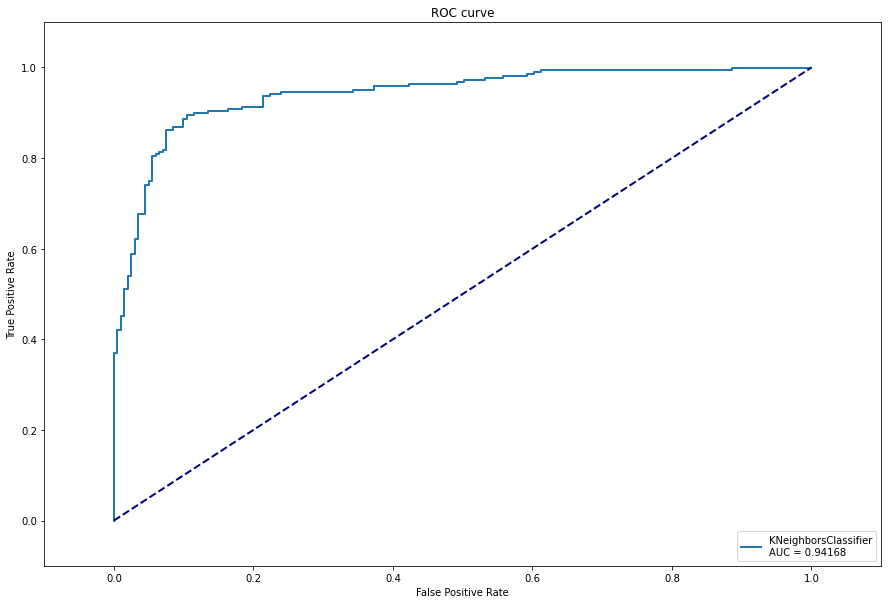

In [136]:
classifier_plot([cv_knn],[scores_knn],X_train,y_train)

In [137]:
best_knn=scores_knn['estimator'][scores_log_reg['test_f1_micro'].argmax()]

In [138]:
print(classification_report(y_test,best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       493
           1       0.85      0.87      0.86       407

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



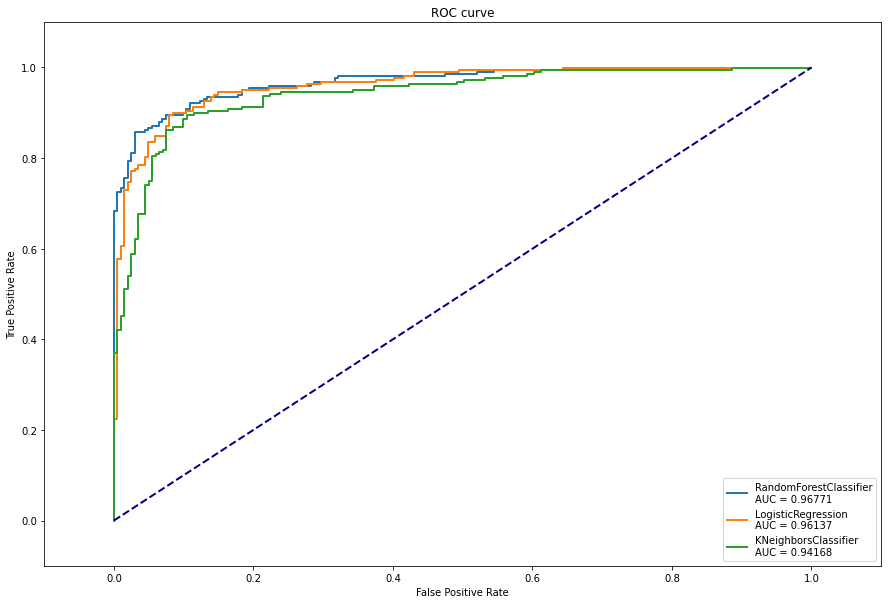

In [139]:
classifier_plot([cv_rfc, cv_log_reg, cv_knn],[scores_rfc, scores_log_reg, scores_knn],X_train,y_train)